<div style="text-align: center;">
    <h1><strong>Portfolio Optimization Using Genetic Algorithms</h1>
    <h4>Filippo Antonio Ronzino - Bocconi University - May 2025</h4>
</div>

## Table of Contents
1. [Framework](#framework)
2. [Problem Formulation](#problem-formulation)
3. [Genetic Algorithm: NGSA-II](#genetic-algorithm)
4. [Implementation](#implementation)
5. [Conclusions](#conclusions)

## 1. Framework

Portfolio optimization represents a central and dynamic area within financial mathematics. Since the seminal work of Harry Markowitz and the introduction of Modern Portfolio Theory (MPT), a wide range of analytical and numerical techniques have been developed to construct optimal investment portfolios based on a predefined universe of assets. Markowitz’s 1959 framework, commonly known as the mean-variance model, formulates the portfolio selection problem as a quadratic optimization task. Specifically, the model seeks to either minimize portfolio variance (risk) for a given expected return, or maximize expected return for a given level of risk. In recent decades, heuristic and metaheuristic methods - most notably Genetic Algorithms (GAs) - have emerged as powerful tools to solve this inherently non-convex optimization problem, especially when dealing with real-world constraints and large asset universes.

## 2. Problem Formulation

Consider a financial market consisting of $n$ risky assets, indexed from $1$ to $n$, and modeled by a probability space $(\Omega, \mathcal{F}, P)$. Let agents act their investment decisions over a one-period horizon with respect to the following set of feasible, or admissible, portfolios defined according to the budget constraint and no-short selling:
\begin{equation*}
\mathcal{X} = \left\{ (x_1, \ldots, x_n) \in \mathbb{R}^n : \sum_{i=1}^n x_i = 1, x_i \geq 0, i = 1, \ldots, n \right\},
\end{equation*}
where $x_i$ represents the proportion of capital to be allocated to asset $i$, with $i$ ranging from $1$ to n.

Define the rate of return of a portfolio $\mathbf{x} = (x_1, ... , x_n)^{\text{T}} \in \mathcal{X}$ as the random variable $R(\mathbf{x}) = \sum_{i=1}^n x_i R_i$, where $R_i$ is the rate of return of asset $i$. The expected return of the portfolio is given by:
\begin{equation*}
\mathbb{E}[R(\mathbf{x})] = \sum_{i=1}^n x_i \mathbb{E}[R_i],
\end{equation*}
where clearly $\mathbb{E}[R_i]$ is the expected return of asset $i$. 

Similarly, the loss distribution is defined as the negative of the portfolio return distribution, that is:
\begin{equation*}
L(\mathbf{x}) = -R(\mathbf{x}) = -\sum_{i=1}^n x_i R_i.
\end{equation*}

To identify the portfolio in $\mathcal{X}$ that guarantees the *best* rate of return, usually the so-called reward-risk approach that relates the portfolio selection problem to a **multi-objective** optimization problem in two steps is adopted:
1. First, a set of objectives that the investor perceives as beneficial is identified;
2. Second, a set of objectives he or she considers damaging is identified in relation to $R$. 

Then this setting is endowed with preference relations based on Pareto dominance, that is a portfolio $\mathbf{x^*} \in \mathcal{X}$ is optimal if and only if it is non-dominated with respect to $\mathcal{X}$, that is, another $\mathbf{x} \in \mathcal{X}$ that dominates $\mathbf{x^*}$ does not exist.

The most common objective, the one derived from the mean-variance model, is to maximize the expected return of the portfolio while minimizing its variance, leading to the following multi-objective optimization problem:
\begin{equation*}
\begin{aligned}
& \text{maximize} & & \mathbb{E}[R(\mathbf{x})] = \sum_{i=1}^n x_i \mathbb{E}[R_i] \\
& \text{minimize} & & \text{Var}(R(\mathbf{x})) = \sum_{i=1}^n \sum_{j=1}^n x_i x_j \text{Cov}(R_i, R_j) \\
& \text{subject to} & & \mathbf{x} \in \mathcal{X}, \quad \sum_{i=1}^n x_i = 1, \quad x_i \geq 0, \, \forall i = 1, \ldots, n.
\end{aligned}
\end{equation*}

Summing up, our ultimate goal is to find a portfolio $\mathbf{x^*} \in \mathcal{X}$ that maximizes the expected return while minimizing the variance of the portfolio return. This is a classic example of a multi-objective optimization problem, where we aim to find a set of Pareto-optimal solutions that represent the best trade-offs between the conflicting objectives of maximizing return and minimizing risk.

## 3. Genetic Algorithm: NGSA-II
The NSGA-II algorithm is a widely used evolutionary algorithm that is designed to solve multi-objective optimization problems, like the one we described above, by evolving a population of solutions over several generations. It operates by maintaining a set of candidate portfolios, which are evaluated based on their objective functions - in this case, the expected return and variance. 

The algorithm’s key components, namely *non-dominated sorting* and *crowding distance*, ensure that the resulting solutions represent a diverse set of trade-offs between the objectives, thus approximating the Pareto front:

- **Non-Dominated Sorting**: In each generation, the portfolios are ranked according to their dominance. A portfolio $\mathbf{x_1}$ is said to dominate another portfolio $\mathbf{x_2}$ if it is at least as good as $\mathbf{x_2}$ in both objectives and strictly better in at least one. Non-dominated sorting classifies portfolios into different "fronts" based on this dominance relationship. The first front consists of the non-dominated solutions (i.e., those that are not dominated by any other solution), the second front contains solutions dominated by only the solutions in the first front, and so on.
- **Crowding Distance**: After sorting the population into fronts, NSGA-II uses crowding distance to maintain diversity within each front. The crowding distance of a portfolio $\mathbf{x}$ in a given front is a measure of how close it is to its neighbors in the objective space. A higher crowding distance indicates that the portfolio is located in a less crowded area of the Pareto front, encouraging the algorithm to preserve diverse solutions. This step helps avoid premature convergence to a suboptimal part of the Pareto front.

Once the population is sorted and diversity is maintained, the algorithm proceeds with the selection of individuals for reproduction. Selection is based on a combination of non-dominated sorting and crowding distance, ensuring that the most promising and diverse solutions are chosen. These selected individuals undergo crossover and mutation operations to produce offspring. Crossover combines the genetic material of two parent solutions, while mutation introduces small random changes to maintain genetic diversity. The offspring are then evaluated and added to the population, and the process repeats over multiple generations.

The result of running NSGA-II for several generations will be a set of Pareto-optimal portfolios that offer the best trade-offs between expected return and variance. 

## 4. Implementation

Let us preliminary import the required libraries:

In [16]:
!pip install matplotlib numpy pandas yfinance

In [17]:
import random
from copy import deepcopy
from datetime import datetime
from enum import Enum

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf

We first define some helper functions:
- `calculate_portfolio_performance`: to compute our portfolio statistics, such as the expected return, variance and Sharpe Ratio, which is a measure of risk-adjusted return, defined as the ratio of the expected excess return of the portfolio to its standard deviation:
\begin{equation*}
\text{Sharpe Ratio} = \frac{\mathbb{E}[R(\mathbf{x})] - r_f}{\sqrt{\text{Var}(R(\mathbf{x}))}},
\end{equation*}
where $r_f$ is the risk-free rate, i.e. the return of a risk-free asset. Intuitively, the Sharpe Ratio measures how much excess return you are receiving for the extra volatility that you endure for holding a riskier asset. A higher Sharpe Ratio indicates a more attractive risk-adjusted return.
- `dominates`: to check if one portfolio dominates another based on the Pareto dominance criteria.
- `crowding_distance`: to calculate the crowding distance of each portfolio in the population, explained above.
- `non_dominated_sorting`: to perform non-dominated sorting of the population, again, explained above.

In [18]:
def calculate_portfolio_performance(weights: np.array, mu: np.array, Sigma: 
                                    np.array, risk_free_rate: float = 0.0) -> tuple:
    """
    Calculates the expected return, variance and Sharpe ratio of a portfolio.

    :param weights: Portfolio weights
    :param mu: Expected returns of assets
    :param Sigma: Covariance matrix of asset returns
    :param risk_free_rate: Risk-free rate for Sharpe ratio calculation
    :return: (expected_return, variance, sharpe_ratio)
    """
    # ensure weights sum to 1 (allowing for small floating point errors)
    if np.abs(np.sum(weights) - 1.0) > 1e-6:
        weights_sum = np.sum(weights)
        if weights_sum > 1e-9: 
             weights = weights / weights_sum
        else: 
            weights = np.ones_like(weights) / len(weights) 

    # ensure non-negativity 
    weights = np.maximum(0, weights)
    if np.abs(np.sum(weights) - 1.0) > 1e-6:
        weights_sum = np.sum(weights)
        if weights_sum > 1e-9:
            weights = weights / weights_sum
        else:
             weights = np.ones_like(weights) / len(weights)

    portfolio_return = np.dot(weights, mu)
    portfolio_variance = np.dot(weights.T, np.dot(Sigma, weights))

    portfolio_variance = max(portfolio_variance, 0)
    portfolio_stddev = np.sqrt(portfolio_variance)

    if portfolio_stddev > 1e-9: 
        sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_stddev
    elif portfolio_return >= risk_free_rate: 
        sharpe_ratio = float('inf')
    else: 
        sharpe_ratio = -float('inf') 

    return portfolio_return, portfolio_variance, sharpe_ratio


def dominates(p1_metrics: tuple, p2_metrics: tuple) -> bool:
    """
    Checks if solution 1 dominates solution 2 based on return-risk objectives.
    For return, higher is better; for variance, lower is better.

    :param p1_metrics: Performance metrics of solution 1 (return, variance)
    :param p2_metrics: Performance metrics of solution 2 (return, variance)
    :return: True if p1 dominates p2, False otherwise
    """
    better_or_equal = p1_metrics[0] >= p2_metrics[0] and p1_metrics[1] <= p2_metrics[1]
    strictly_better = p1_metrics[0] > p2_metrics[0] or p1_metrics[1] < p2_metrics[1]
    return better_or_equal and strictly_better

def non_dominated_sort(population_metrics: list) -> list:
    """
    Performs non-dominated sorting on the population based on return-risk objectives.
    Returns a list of fronts, where each front contains indices of individuals.

    :param population_metrics: List of tuples containing performance metrics (return, variance) for each individual
    :return: List of fronts, where each front is a list of indices
    """
    population_size = len(population_metrics)
    if population_size == 0:
        return []

    dominating_counts = [0] * population_size
    dominated_solutions = [[] for _ in range(population_size)]
    fronts = [[]]  #

    for i in range(population_size):
        for j in range(i + 1, population_size):
            if population_metrics[i] is None or population_metrics[j] is None:
                continue

            p_metrics = population_metrics[i]
            q_metrics = population_metrics[j]

            if dominates(p_metrics, q_metrics):
                dominated_solutions[i].append(j)
                dominating_counts[j] += 1
            elif dominates(q_metrics, p_metrics):
                dominated_solutions[j].append(i)
                dominating_counts[i] += 1

        if dominating_counts[i] == 0:
            fronts[0].append(i)

    front_index = 0
    while fronts[front_index]:
        next_front = []
        for i in fronts[front_index]:
            for j in dominated_solutions[i]:
                dominating_counts[j] -= 1
                if dominating_counts[j] == 0:
                    next_front.append(j)
        front_index += 1
        if next_front:
            fronts.append(next_front)
        else:
            break 

    return fronts


def calculate_crowding_distance(front_indices: list, population_metrics: list) -> dict:
    """
    Calculates the crowding distance for individuals in a front.
    Used for maintaining diversity in the Pareto front.


    :param front_indices: Indices of individuals in the front
    :param population_metrics: Metrics for each individual in the combined population
    :return: Dictionary mapping indices (from the original combined population) to crowding distances
    """
    num_in_front = len(front_indices)
    if num_in_front == 0:
        return {}
    if num_in_front <= 2:
        return {idx: float('inf') for idx in front_indices}

    objectives_to_use = 2  # return (index 0) and variance (index 1)

    distances = {idx: 0.0 for idx in front_indices}

    for obj_index in range(objectives_to_use):
        obj_values = []
        for idx in front_indices:
            if idx < len(population_metrics) and population_metrics[idx] is not None:
                obj_values.append((idx, population_metrics[idx][obj_index]))

        if not obj_values:
            continue

        obj_values.sort(key=lambda x: x[1])

        if len(obj_values) <= 1:
             if len(obj_values) == 1:
                 distances[obj_values[0][0]] = float('inf') 
             continue 

        distances[obj_values[0][0]] = float('inf')
        distances[obj_values[-1][0]] = float('inf')

        obj_min = obj_values[0][1]
        obj_max = obj_values[-1][1]
        obj_range = obj_max - obj_min

        if obj_range > 1e-9:  
            for i in range(1, len(obj_values) - 1):
                idx_current = obj_values[i][0]
                val_prev = obj_values[i-1][1]
                val_next = obj_values[i+1][1]
                distances[idx_current] += (val_next - val_prev) / obj_range
                
    return distances

Once we have defined these functions, we can implement the NSGA-II algorithm. The algorithm will be implemented as a class called `PortfolioOptimizerGA`, which will encapsulate all the necessary methods and attributes to perform the optimization process. The class will include methods for initialization, selection, crossover, mutation, and the main optimization loop.

It is useful for our purposes to have a wrapper around `Enum`, that is `CrossoverType` to define different crossover types, we will allow for the following ones:
- `simple_blend`: Simple Blend Crossover combines the genes of two parents by blending their values, typically using a weighted average to produce offspring within the parents' range;
- `simulated_binary`: Simulated Binary Crossover mimics binary crossover behavior for real-valued genes, using a distribution index to control the degree of variation in the offspring;
- `uniform`: Uniform Crossover randomly selects genes from either parent for each position, creating offspring with a diverse combination of genetic material.

In [19]:
class CrossoverType(Enum):
    SIMPLE_BLEND = "simple_blend"
    SIMULATED_BINARY = "simulated_binary"
    UNIFORM = "uniform"

We can now introduce our main class `PortfolioOptimizerGA`, which will implement the NSGA-II algorithm. The class will include methods for initialization, selection, crossover, mutation, and the main optimization loop. The constructor will take the following parameters:
- `num_assets`: the number of assets in the portfolio;
- `mu`: the expected returns of the assets;
- `sigma`: the covariance matrix of the asset returns;
- `population_size`: the size of the population;
- `generations`: the number of generations to run the algorithm;
- `crossover_rate`: the probability of crossover;
- `mutation_rate`: the probability of mutation;
- `mutation_strength`: the strength of the mutation;
- `crossover_type`: the type of crossover to use, inherited from `CrossoverType`;
- `risk_free_rate`: the risk-free rate to use for Sharpe Ratio calculation;
- `sbx_eta`: the distribution index for Simulated Binary Crossover, it controls offspring similarity to parents - higher values lead to more exploitation (less variation), lower values encourage exploration.
- `poly_mutation_eta`: the distribution index for Polynomial Mutation, it controls mutation step size - higher values lead to finer, more local changes, while lower values allow broader exploration.

Let us see the main methods:
- `_initialize_population()`: creates the initial random population of portfolio weight allocations generateing random weights for each asset and normalizes them to sum to 1;
-  `_evaluate_population()`: calculates key performance metrics for each portfolio in the population, i.e. for each portfolio, computes expected return, variance, and Sharpe ratio;
-  the three ways of crossover, i.e. `_simple_blend_crossover()`, `_simulated_binary_crossover()`, and `_uniform_crossover()`, which will be called based on the `crossover_type` parameter in `_crossover()`;
- `_mutate()`:randomly mutates individual weights according to the mutation rate and distribution;
- `_binary_tournament_selection()`:  the key NSGA-II's binary tournament selection, creates the mating pool by selecting individuals based on Pareto rank and crowding distance. It performs non-dominated sorting, calculates crowding distances, and compares individuals;
- `run()`: the main loop of the NSGA-II algorithm, which iteratively evolves the population over a specified number of generations. It includes selection, crossover, mutation, and evaluation steps, and returns the final population of Pareto-optimal portfolios.

In [20]:
class PortfolioOptimizerGA:
    def __init__(self,
                 num_assets,
                 mu,
                 Sigma,
                 population_size=100,
                 generations=200,
                 crossover_rate=0.9, 
                 mutation_rate=None, 
                 mutation_strength=0.1,
                 crossover_type=CrossoverType.SIMULATED_BINARY,
                 risk_free_rate=0.02,
                 sbx_eta=15.0, 
                 poly_mutation_eta=20.0 
                 ):
        """
        Initializes the Portfolio Optimizer using the NSGA-II algorithm.

        :param num_assets: Number of assets in the portfolio
        :param mu: Expected returns of assets (numpy array)
        :param Sigma: Covariance matrix of asset returns (numpy array)
        :param population_size: Size of the population (number of portfolios)
        :param generations: Number of generations to run the algorithm
        :param crossover_rate: Probability of crossover between parents
        :param mutation_rate: Probability of mutation for each gene (weight)
        :param mutation_strength: Strength of mutation (used in Gaussian mutation)
        :param crossover_type: Type of crossover to use (simple blend, simulated binary, uniform)
        :param risk_free_rate: Risk-free rate for Sharpe ratio calculation
        :param sbx_eta: Distribution index for SBX crossover
        :param poly_mutation_eta: Distribution index for polynomial mutation
        """
        if not isinstance(mu, np.ndarray): 
            mu = np.array(mu)
        if not isinstance(Sigma, np.ndarray): 
            Sigma = np.array(Sigma)

        if mu.shape[0] != num_assets or Sigma.shape != (num_assets, num_assets):
            raise ValueError("Dimensions of mu and Sigma must match num_assets.")
        if population_size % 2 != 0:
            print("Warning: Population size should be even for crossover. Adjusting...")
            population_size += 1

        self.num_assets = num_assets
        self.mu = mu
        self.Sigma = Sigma
        self.population_size = population_size
        self.generations = generations
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate if mutation_rate is not None else 1.0 / num_assets
        self.mutation_strength = mutation_strength 
        self.crossover_type = crossover_type
        self.risk_free_rate = risk_free_rate
        self.sbx_eta = sbx_eta
        self.poly_mutation_eta = poly_mutation_eta 

        self.population = self._initialize_population()
        self.population_metrics = self._evaluate_population(self.population)
        self.history = []

        print(f"Initialized NSGA-II optimizer: Pop={population_size}, Gen={generations}, Assets={num_assets}")
        print(f"Crossover: {crossover_type.value} (Rate={self.crossover_rate}, SBX eta={sbx_eta})")
        print(f"Mutation: Polynomial (Rate={self.mutation_rate:.4f}, eta={self.poly_mutation_eta}) / Gaussian (Strength={self.mutation_strength})")


    def _initialize_population(self) -> list:
        """
        Creates the initial population with random weights summing to 1
        
        :return: List of individuals (portfolios)
        """
        population = []
        for _ in range(self.population_size):
            weights = np.random.rand(self.num_assets)
            weights_sum = np.sum(weights)
            if weights_sum > 1e-9:
                 weights /= weights_sum
            else: # rare case of all zeros
                 weights = np.ones(self.num_assets) / self.num_assets
            population.append(weights)
        return population

    def _evaluate_population(self, population: list) -> list:
        """
        Calculates return, variance, and Sharpe ratio for each individual in the population.

        :param population: List of individuals (portfolios)
        :return: List of tuples containing (expected_return, variance, sharpe_ratio) for each individual
        """
        metrics = []
        for ind in population:
             try:
                 perf = calculate_portfolio_performance(ind, self.mu, self.Sigma, self.risk_free_rate)
                 metrics.append(perf)
             except Exception as e:
                 print(f"Warning: Error evaluating individual {ind}: {e}")
                 metrics.append((-float('inf'), float('inf'), -float('inf'))) # assign worst possible metrics, poor fitness
        return metrics


    def _simple_blend_crossover(self, parent1, parent2) -> tuple:
        """
        Simple blend (average) crossover.
        
        :param parent1: First parent portfolio
        :param parent2: Second parent portfolio
        :return: Two children portfolios
        """
        alpha = random.random()  # blend factor
        child1 = alpha * parent1 + (1 - alpha) * parent2
        child2 = (1 - alpha) * parent1 + alpha * parent2

        sum1 = np.sum(child1)
        sum2 = np.sum(child2)
        if sum1 > 1e-9: 
            child1 /= sum1
        else: 
            child1 = np.ones_like(child1) / self.num_assets
        if sum2 > 1e-9: 
            child2 /= sum2
        else: 
            child2 = np.ones_like(child2) / self.num_assets

        child1 = np.maximum(0, child1)
        child2 = np.maximum(0, child2)
        sum1 = np.sum(child1)
        sum2 = np.sum(child2)

        if sum1 > 1e-9: 
            child1 /= sum1
        else: 
            child1 = np.ones_like(child1) / self.num_assets
        if sum2 > 1e-9: 
            child2 /= sum2
        else: 
            child2 = np.ones_like(child2) / self.num_assets


        return child1, child2

    def _simulated_binary_crossover(self, parent1, parent2) -> tuple:
        """
        Simulated Binary Crossover (SBX) for real-valued genes.
        Creates two children that are more likely to be near their parents.

        :param parent1: First parent portfolio
        :param parent2: Second parent portfolio
        :return: Two children portfolios
        """
        child1 = np.zeros_like(parent1)
        child2 = np.zeros_like(parent2)
        eta = self.sbx_eta 

        for i in range(self.num_assets):
            u = random.random()
            if u <= 0.5:
                beta = (2.0 * u) ** (1.0 / (eta + 1.0))
            else:
                beta = (1.0 / (2.0 * (1.0 - u))) ** (1.0 / (eta + 1.0))

            p1_gene = parent1[i]
            p2_gene = parent2[i]

            c1_gene = 0.5 * ((1 + beta) * p1_gene + (1 - beta) * p2_gene)
            c2_gene = 0.5 * ((1 - beta) * p1_gene + (1 + beta) * p2_gene)

            child1[i] = max(0.0, c1_gene)
            child2[i] = max(0.0, c2_gene)

        sum1 = np.sum(child1)
        sum2 = np.sum(child2)
        if sum1 > 1e-9:
            child1 /= sum1
        else:
            child1 = np.ones_like(child1) / self.num_assets
        if sum2 > 1e-9:
            child2 /= sum2
        else:
            child2 = np.ones_like(child2) / self.num_assets

        return child1, child2

    def _uniform_crossover(self, parent1, parent2) -> tuple:
        """
        Uniform crossover with weight correction.
        Each gene has a 50% chance to be inherited from either parent.

        :param parent1: First parent portfolio
        :param parent2: Second parent portfolio
        :return: Two children portfolios
        """
        child1 = np.zeros_like(parent1)
        child2 = np.zeros_like(parent2)

        for i in range(self.num_assets):
            if random.random() < 0.5:
                child1[i] = parent1[i]
                child2[i] = parent2[i]
            else:
                child1[i] = parent2[i]
                child2[i] = parent1[i]

        sum1 = np.sum(child1)
        sum2 = np.sum(child2)
        if sum1 > 1e-9: 
            child1 /= sum1
        else:
            child1 = np.ones_like(child1) / self.num_assets
        if sum2 > 1e-9:
            child2 /= sum2
        else:
            child2 = np.ones_like(child2) / self.num_assets

        return child1, child2

    def _crossover(self, parent1, parent2) -> tuple:
        """
        Performs the selected type of crossover based on crossover_type.
        
        :param parent1: First parent portfolio
        :param parent2: Second parent portfolio
        :return: Two children portfolios
        """
        if random.random() < self.crossover_rate:
            if self.crossover_type == CrossoverType.SIMULATED_BINARY:
                return self._simulated_binary_crossover(parent1, parent2)
            elif self.crossover_type == CrossoverType.UNIFORM:
                return self._uniform_crossover(parent1, parent2)
            else:  # Default: SIMPLE_BLEND
                return self._simple_blend_crossover(parent1, parent2)
        else: # parents pass through (return copies), no crossover
            return parent1.copy(), parent2.copy()

    def _mutate(self, individual) -> np.array:
        """
        Applies Polynomial Mutation to an individual.
        Falls back to Gaussian mutation if polynomial calculation has issues.
        """
        mutated_individual = individual.copy()
        eta = self.poly_mutation_eta
        low_bound = 0.0 
        high_bound = 1.0   

        mutated = False

        for i in range(self.num_assets):
            if random.random() < self.mutation_rate:
                mutated = True
                current_val = mutated_individual[i]
                u = random.random()

                # calculate delta based on polynomial distribution
                if u < 0.5:
                    delta_q = (2.0 * u) ** (1.0 / (eta + 1.0)) - 1.0
                    new_val = current_val + delta_q * (current_val - low_bound)
                else:
                    delta_q = 1.0 - (2.0 * (1.0 - u)) ** (1.0 / (eta + 1.0))
                    new_val = current_val + delta_q * (high_bound - current_val)

                mutated_individual[i] = max(low_bound, min(new_val, high_bound))

        # normalize weights only if mutation occurred and sum changed significantly
        if mutated:
            current_sum = np.sum(mutated_individual)
            if abs(current_sum - 1.0) > 1e-6: 
                if current_sum > 1e-9:
                     mutated_individual /= current_sum
                else: # case where mutation leads to all zeros
                    mutated_individual = np.ones_like(mutated_individual) / self.num_assets


        return mutated_individual


    def _binary_tournament_selection(self, population, metrics) -> list:
        """
        Binary tournament selection based on Pareto rank and crowding distance.
        This is the standard NSGA-II selection method for creating the mating pool.

        :param population: Current population of portfolios
        :param metrics: Performance metrics for each portfolio
        :return: Selected individuals for the mating pool
        """
        n = len(population)
        selected = []

        fronts = non_dominated_sort(metrics)

        ranks = {}
        for i, front in enumerate(fronts):
            for idx in front:
                ranks[idx] = i

        crowding_distances = {}
        for front in fronts:
            front_crowding = calculate_crowding_distance(front, metrics)
            for idx, distance in front_crowding.items():
                crowding_distances[idx] = distance if idx in front else 0.0


        for _ in range(n):
            i, j = random.sample(range(n), 2)

            rank_i = ranks.get(i, float('inf')) 
            rank_j = ranks.get(j, float('inf'))
            dist_i = crowding_distances.get(i, 0.0) 
            dist_j = crowding_distances.get(j, 0.0)

            # Compare based on rank and crowding distance
            if rank_i < rank_j:
                selected.append(population[i])
            elif rank_j < rank_i:
                selected.append(population[j])
            # If ranks are equal, higher crowding distance is better
            elif dist_i > dist_j:
                selected.append(population[i])
            elif dist_j > dist_i:
                selected.append(population[j])
            # If rank and distance are the same, choose one randomly
            else:
                selected.append(random.choice([population[i], population[j]]))

        return selected


    def run(self) -> tuple:
        """
        Executes the NSGA-II algorithm.
        """
        print(f"Starting NSGA-II: Pop Size={self.population_size}, Generations={self.generations}")
        print(f"Assets={self.num_assets}, Crossover={self.crossover_rate}, Mutation={self.mutation_rate:.4f}")
        print(f"Using {self.crossover_type.value} crossover with return-risk objectives")

        for generation in range(self.generations):
            # 1. create Mating Pool using Binary Tournament Selection
            mating_pool = self._binary_tournament_selection(self.population, self.population_metrics)

            # 2. create Offspring Population (Qt) using Crossover and Mutation
            offspring = []
            for i in range(0, self.population_size, 2):
                idx1 = i
                idx2 = (i + 1) % self.population_size 

                parent1 = mating_pool[idx1]
                parent2 = mating_pool[idx2]

                child1, child2 = self._crossover(parent1, parent2)

                mutated_child1 = self._mutate(child1)
                mutated_child2 = self._mutate(child2)

                offspring.append(mutated_child1)
                offspring.append(mutated_child2)

            # ensure offspring population has the correct size if population_size was odd initially
            offspring = offspring[:self.population_size]


            # 3. evaluate Offspring Population
            offspring_metrics = self._evaluate_population(offspring)

            # 4. combine Parent (Pt) and Offspring (Qt) Populations -> Rt
            combined_population = self.population + offspring
            combined_metrics = self.population_metrics + offspring_metrics

            # 5. non-dominated Sort on Combined Population (Rt)
            valid_indices = [i for i, m in enumerate(combined_metrics) if m is not None]
            if len(valid_indices) < len(combined_metrics):
                 print(f"Warning: Generation {generation + 1}: Found {len(combined_metrics) - len(valid_indices)} individuals with invalid metrics.")
                 
            fronts = non_dominated_sort(combined_metrics)

            if not fronts or not fronts[0]:
                print(f"Warning: Generation {generation + 1}: Non-dominated sort failed or returned empty fronts. Population might be unstable.")
                if not self.population: 
                    print("Error: Population empty and sorting failed. Reinitializing.")
                    self.population = self._initialize_population()
                    self.population_metrics = self._evaluate_population(self.population)
                continue # skip to next generation


            # 6. select Next Generation (Pt+1) based on Rank and Crowding Distance
            new_population = []
            new_metrics = []
            front_idx = 0

            while len(new_population) < self.population_size and front_idx < len(fronts):
                current_front_indices = fronts[front_idx]
                needed = self.population_size - len(new_population)

                if len(current_front_indices) <= needed:
                    for idx in current_front_indices:
                        if idx < len(combined_population) and combined_metrics[idx] is not None:
                            new_population.append(combined_population[idx])
                            new_metrics.append(combined_metrics[idx])
                    front_idx += 1
                else:
                    crowding_distances = calculate_crowding_distance(current_front_indices, combined_metrics)

                    valid_front_indices = [idx for idx in current_front_indices if idx in crowding_distances]
                    sorted_front = sorted(valid_front_indices, key=lambda idx: crowding_distances[idx], reverse=True)

                    for i in range(needed):
                         if i < len(sorted_front):
                            idx = sorted_front[i]
                            if idx < len(combined_population) and combined_metrics[idx] is not None:
                                new_population.append(combined_population[idx])
                                new_metrics.append(combined_metrics[idx])
                    break

    
            self.population = new_population[:self.population_size]
            self.population_metrics = new_metrics[:self.population_size]

            current_pareto_indices = fronts[0] if fronts else []
            current_pareto_metrics = [combined_metrics[i] for i in current_pareto_indices if i < len(combined_metrics) and combined_metrics[i] is not None]

            self.history.append({
                'generation': generation,
                'pareto_metrics': deepcopy(current_pareto_metrics),
                'population': None # Optionally store population snapshots less frequently
                # 'population': deepcopy(self.population) if generation % 20 == 0 else None
            })

            if (generation + 1) % (max(1, self.generations // 10)) == 0 or generation == 0:
                 if self.population_metrics:
                     best_current_metrics = self.population_metrics[0]
                     print(f"Generation {generation + 1}/{self.generations} - "
                           f"Sample Best Return: {best_current_metrics[0]:.4f}, "
                           f"Risk: {np.sqrt(max(0,best_current_metrics[1])):.4f}, " # Use max(0,.) for safety
                           f"Sharpe: {best_current_metrics[2]:.4f} "
                           f"(Fronts found: {len(fronts)}, Pareto size: {len(current_pareto_indices)})")

                 else:
                    print(f"Generation {generation + 1}/{self.generations} - Population empty or invalid.")

        final_fronts = non_dominated_sort(self.population_metrics)
        if not final_fronts or not final_fronts[0]:
             print("Warning: Final non-dominated sort yielded empty front.")
             pareto_front_indices = list(range(len(self.population))) 
        else:
            pareto_front_indices = final_fronts[0]

        pareto_front_solutions = [self.population[i] for i in pareto_front_indices if i < len(self.population)]
        pareto_front_metrics = [self.population_metrics[i] for i in pareto_front_indices if i < len(self.population_metrics)]

        print(f"NSGA-II finished. Found {len(pareto_front_solutions)} non-dominated solutions in the final population.")
        return pareto_front_solutions, pareto_front_metrics


    def plot_efficient_frontier(self, pareto_metrics, all_metrics_history=None) -> None:
        """
        Plots the efficient frontier (return-risk Pareto front) with Sharpe ratio highlighted.
        
        :param pareto_metrics: List of Pareto front metrics (return, variance, Sharpe ratio)
        :param all_metrics_history: Optional history of metrics from all generations
        """
        if not pareto_metrics:
             print("No Pareto front metrics to plot.")
             return

        plt.figure(figsize=(12, 7))

        if all_metrics_history:
            all_returns_hist = []
            all_risks_hist = []
            for gen_data in all_metrics_history:
                 metrics_list = gen_data.get('pareto_metrics') 
                 if metrics_list:
                     for m in metrics_list:
                         if m: 
                            all_returns_hist.append(m[0])
                            all_risks_hist.append(np.sqrt(max(0, m[1]))) 

            if all_risks_hist: 
                plt.scatter(all_risks_hist, all_returns_hist, c='lightgray', marker='.', alpha=0.2, label='Explored Solutions (History)')

        returns = [m[0] for m in pareto_metrics if m]
        risks = [np.sqrt(max(0, m[1])) for m in pareto_metrics if m]  
        sharpes = [m[2] for m in pareto_metrics if m]

        if not risks: 
             print("No valid Pareto front points found to plot.")
             plt.title('Efficient Frontier: Return vs Risk (No Valid Pareto Points)')
             plt.xlabel('Portfolio Risk (Standard Deviation)')
             plt.ylabel('Expected Portfolio Return')
             plt.grid(True, alpha=0.3)
             plt.legend()
             plt.tight_layout()
             plt.show()
             return

        frontier_points = sorted(zip(risks, returns, sharpes), key=lambda x: x[0])
        frontier_risks = [r for r, _, _ in frontier_points]
        frontier_returns = [ret for _, ret, _ in frontier_points]

        plt.plot(frontier_risks, frontier_returns, 'b-', linewidth=2, marker='o', markersize=4, alpha=0.7, label='Efficient Frontier')

        sc = plt.scatter(frontier_risks, frontier_returns, c=[s for _, _, s in frontier_points], cmap='viridis', marker='o',
                         s=100, alpha=0.9, edgecolors='k', linewidth=0.5, label='Pareto Solutions')

        if sharpes: 
            max_sharpe_val = -float('inf')
            max_sharpe_idx = -1
            for i, s in enumerate(sharpes):
                 if np.isfinite(s) and s > max_sharpe_val:
                     max_sharpe_val = s
                     max_sharpe_idx = i
                 elif s == float('inf') and max_sharpe_val != float('inf'):
                     max_sharpe_val = s
                     max_sharpe_idx = i


            if max_sharpe_idx != -1:
                 plt.scatter([risks[max_sharpe_idx]], [returns[max_sharpe_idx]],
                             marker='*', color='red', s=350, edgecolors='black',
                             label=f'Max Sharpe ({max_sharpe_val:.4f})')
            else:
                 print("Could not find a best Sharpe point (all might be non-finite or list empty).")

        cbar = plt.colorbar(sc)
        cbar.set_label('Sharpe Ratio')

        plt.title('Efficient Frontier: Return vs Risk (NSGA-II)')
        plt.xlabel('Portfolio Risk (Standard Deviation)')
        plt.ylabel('Expected Portfolio Return')
        plt.grid(True, alpha=0.5)
        plt.legend()
        plt.tight_layout()
        plt.show()

    def get_best_portfolio(self, criterion: str = 'sharpe') -> tuple:
        """
        Returns the 'best' portfolio from the final population based on a criterion.
        Note: For multi-objective, 'best' is subjective. This picks one point.
        For Pareto front, consider returning the point maximizing the criterion *from the front*.

        :param criterion: 'sharpe', 'return', or 'risk' to select the best portfolio
        :return: Tuple of (best portfolio, corresponding metrics)
        """
        final_pareto_solutions, final_pareto_metrics = self.run() 
        # TODO: Modify class to store final results instead of re-running.
    
        final_fronts = non_dominated_sort(self.population_metrics)
        if not final_fronts or not final_fronts[0]:
            print("Cannot get best portfolio: No non-dominated front found in final population.")
            metrics_to_search = self.population_metrics
            population_to_search = self.population
            indices_to_search = list(range(len(metrics_to_search)))
            if not metrics_to_search: return None, None # Nothing to search
            print("Warning: Selecting best from entire final population as Pareto front is empty.")
        else:
            pareto_indices = final_fronts[0]
            metrics_to_search = [self.population_metrics[i] for i in pareto_indices if i < len(self.population_metrics)]
            population_to_search = [self.population[i] for i in pareto_indices if i < len(self.population)]
            indices_to_search = list(range(len(metrics_to_search)))
            if not metrics_to_search:
                print("Cannot get best portfolio: Pareto front exists but contains no valid metrics.")
                return None, None


        best_idx = -1
        if criterion == 'sharpe':
            finite_sharpes = [(i, m[2]) for i, m in enumerate(metrics_to_search) if m and np.isfinite(m[2])]
            inf_sharpes = [(i, m[2]) for i, m in enumerate(metrics_to_search) if m and m[2] == float('inf')]

            if inf_sharpes: 
                 best_idx = inf_sharpes[0][0] 
            elif finite_sharpes:
                 best_idx = max(finite_sharpes, key=lambda item: item[1])[0]

        elif criterion == 'return':
            finite_returns = [(i, m[0]) for i, m in enumerate(metrics_to_search) if m and np.isfinite(m[0])]
            if finite_returns:
                 best_idx = max(finite_returns, key=lambda item: item[1])[0]
        elif criterion == 'risk':
             finite_risks = [(i, m[1]) for i, m in enumerate(metrics_to_search) if m and np.isfinite(m[1])]
             if finite_risks:
                 best_idx = min(finite_risks, key=lambda item: item[1])[0]

        else:
            raise ValueError("Invalid criterion. Choose 'sharpe', 'return', or 'risk'.")

        if best_idx != -1 and best_idx < len(population_to_search):
            original_best_idx = indices_to_search[best_idx]
            return population_to_search[original_best_idx], metrics_to_search[original_best_idx]
        else:
            print(f"Could not find a best portfolio for criterion '{criterion}'.")
            return None, None 

    def plot_convergence(self) -> None:
        """
        Plots the convergence of key metrics over generations using stored history.
        """
        if not self.history:
            print("No history available to plot convergence.")
            return

        generations = [h['generation'] for h in self.history]

        max_returns_pareto = []
        min_risks_pareto = []
        max_sharpes_pareto = []

        for h in self.history:
            pareto_metrics = h.get('pareto_metrics', [])
            valid_metrics = [m for m in pareto_metrics if m] 

            if valid_metrics:
                 max_ret = max(m[0] for m in valid_metrics if np.isfinite(m[0])) if any(np.isfinite(m[0]) for m in valid_metrics) else np.nan
                 max_returns_pareto.append(max_ret)

                 min_var = min(m[1] for m in valid_metrics if np.isfinite(m[1])) if any(np.isfinite(m[1]) for m in valid_metrics) else np.nan
                 min_risks_pareto.append(np.sqrt(max(0, min_var)) if np.isfinite(min_var) else np.nan) # Use max(0,.)

                 finite_sharpes = [m[2] for m in valid_metrics if np.isfinite(m[2])]
                 has_inf_sharpe = any(m[2] == float('inf') for m in valid_metrics)

                 if has_inf_sharpe:
                     max_shp = float('inf')
                 elif finite_sharpes:
                      max_shp = max(finite_sharpes)
                 else: 
                      max_shp = np.nan
                 max_sharpes_pareto.append(max_shp)

            else: 
                max_returns_pareto.append(np.nan)
                min_risks_pareto.append(np.nan)
                max_sharpes_pareto.append(np.nan)


        plt.figure(figsize=(18, 6))

        plt.subplot(1, 3, 1)
        plt.plot(generations, max_returns_pareto, marker='.', linestyle='-')
        plt.title('Max Return on Pareto Front')
        plt.xlabel('Generation')
        plt.ylabel('Expected Return')
        plt.grid(True, alpha=0.5)
        plt.ylim(bottom=min(r for r in max_returns_pareto if np.isfinite(r)) * 0.9 if any(np.isfinite(r) for r in max_returns_pareto) else 0)


        plt.subplot(1, 3, 2)
        plt.plot(generations, min_risks_pareto, marker='.', linestyle='-')
        plt.title('Min Risk (Std Dev) on Pareto Front')
        plt.xlabel('Generation')
        plt.ylabel('Portfolio Risk (Std Dev)')
        plt.grid(True, alpha=0.5)
        plt.ylim(bottom=0) 

        plt.subplot(1, 3, 3)
        plot_sharpes = [s if np.isfinite(s) else np.nan for s in max_sharpes_pareto] 
        has_inf = any(s == float('inf') for s in max_sharpes_pareto)

        plt.plot(generations, plot_sharpes, marker='.', linestyle='-')
        plt.title(f'Max Sharpe Ratio on Pareto Front{" (Inf values present)" if has_inf else ""}')
        plt.xlabel('Generation')
        plt.ylabel('Sharpe Ratio')
        plt.grid(True, alpha=0.5)
        finite_max = max((s for s in plot_sharpes if np.isfinite(s)), default=1)
        plt.ylim(top=finite_max * 1.2 if not has_inf else None)


        plt.suptitle('NSGA-II Convergence Metrics (Pareto Front Extremes)')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
        plt.show()


def get_stock_data(tickers: list, start_date: datetime = None, end_date: datetime = None, period: str = "2y") -> tuple:
    """
    Fetches stock data for the given tickers using yfinance.
    Calculates annualized expected returns and covariance matrix.

    :param tickers: List of stock tickers (e.g., ['AAPL', 'MSFT'])
    :param start_date: Start date for historical data (format: 'YYYY-MM-DD')
    :param end_date: End date for historical data (format: 'YYYY-MM-DD')
    :param period: Period for historical data (e.g., '1y', '2y', '5y')
    :return: Tuple of (annualized returns, covariance matrix, valid tickers)
    """
    if end_date is None:
        end_date = datetime.now().strftime('%Y-%m-%d')

    print(f"Fetching data for {tickers}...")
    try:
        if start_date:
            print(f"Using date range: {start_date} to {end_date}")
            data = yf.download(tickers, start=start_date, end=end_date, progress=False)
        else:
            print(f"Using period: {period}")
            data = yf.download(tickers, period=period, end=end_date, progress=False)

        if data.empty:
            print("Error: No data downloaded. Check tickers and date range/period.")
            return None, None, None

        if isinstance(data['Close'], pd.Series):
             close = data[['Close']].copy() 
             close.columns = tickers 
        else:
             close = data['Close']

        if close.isnull().values.any():
            print("Warning: Missing close price data found. Filling forward, then backward.")
            close = close.ffill().bfill() 

        close = close.dropna(axis=1, how='all')
        if close.empty:
             print("Error: All asset data is missing after cleaning.")
             return None, None, None

        valid_tickers = close.columns.tolist()
        print(f"Using data for valid tickers: {valid_tickers}")

        # Calculate daily returns
        daily_returns = close.pct_change().dropna() 

        if daily_returns.empty:
            print("Error: Not enough data to calculate returns.")
            return None, None, None

        mean_returns = daily_returns.mean() * 252  
        cov_matrix = daily_returns.cov() * 252

        if mean_returns.shape[0] != len(valid_tickers) or cov_matrix.shape != (len(valid_tickers), len(valid_tickers)):
             print("Error: Dimension mismatch after processing data.")
             return None, None, None


        return mean_returns.values, cov_matrix.values, valid_tickers

    except Exception as e:
        print(f"Error fetching or processing stock data: {e}")
        return None, None, None

At the end we also included some utility functions to visualize the results, inspect the Pareto front and get real stock data to test the algorithm:
- `plot_efficient_frontier()`: to visualize the efficient frontier of the Pareto-optimal portfolios;
- `get_best_portfolio()`: retrieves the optimal portfolio based on a specific criterion: maximum Sharpe ratio, maximum return, or minimum risk;
- `plot_convergence()`: visualizes the algorithm's convergence over generations;
- `get_stock_data()`: fetches historical stock data for portfolio optimization: downloads price data using `yfinance`, calculates annualized returns and covariance.

Let us now run the algorithm on a real dataset of 10 stocks by fetching daily closing prices with the get_stock_data() function, from 2018-01-01 to 2024-12-31. We will use a 3% risk-free rate, then apply NSGA-II, visualize the results, and evaluate the performance of the optimized portfolios.

Fetching data for ['AAPL', 'MSFT', 'AMZN', 'BRK-B', 'JNJ', 'JPM', 'V', 'PG', 'XOM', 'BAC']...
Using date range: 2018-01-01 to 2024-12-31
Using data for valid tickers: ['AAPL', 'AMZN', 'BAC', 'BRK-B', 'JNJ', 'JPM', 'MSFT', 'PG', 'V', 'XOM']

Successfully loaded data for 10 assets: ['AAPL', 'AMZN', 'BAC', 'BRK-B', 'JNJ', 'JPM', 'MSFT', 'PG', 'V', 'XOM']
Initialized NSGA-II optimizer: Pop=100, Gen=150, Assets=10
Crossover: simple_blend (Rate=0.9, SBX eta=15.0)
Mutation: Polynomial (Rate=0.1000, eta=20.0) / Gaussian (Strength=0.1)
Starting NSGA-II: Pop Size=100, Generations=150
Assets=10, Crossover=0.9, Mutation=0.1000
Using simple_blend crossover with return-risk objectives
Generation 1/150 - Sample Best Return: 0.1804, Risk: 0.1928, Sharpe: 0.7802 (Fronts found: 19, Pareto size: 15)
Generation 15/150 - Sample Best Return: 0.2091, Risk: 0.2045, Sharpe: 0.8755 (Fronts found: 6, Pareto size: 57)
Generation 30/150 - Sample Best Return: 0.1617, Risk: 0.1751, Sharpe: 0.7519 (Fronts found: 6, P

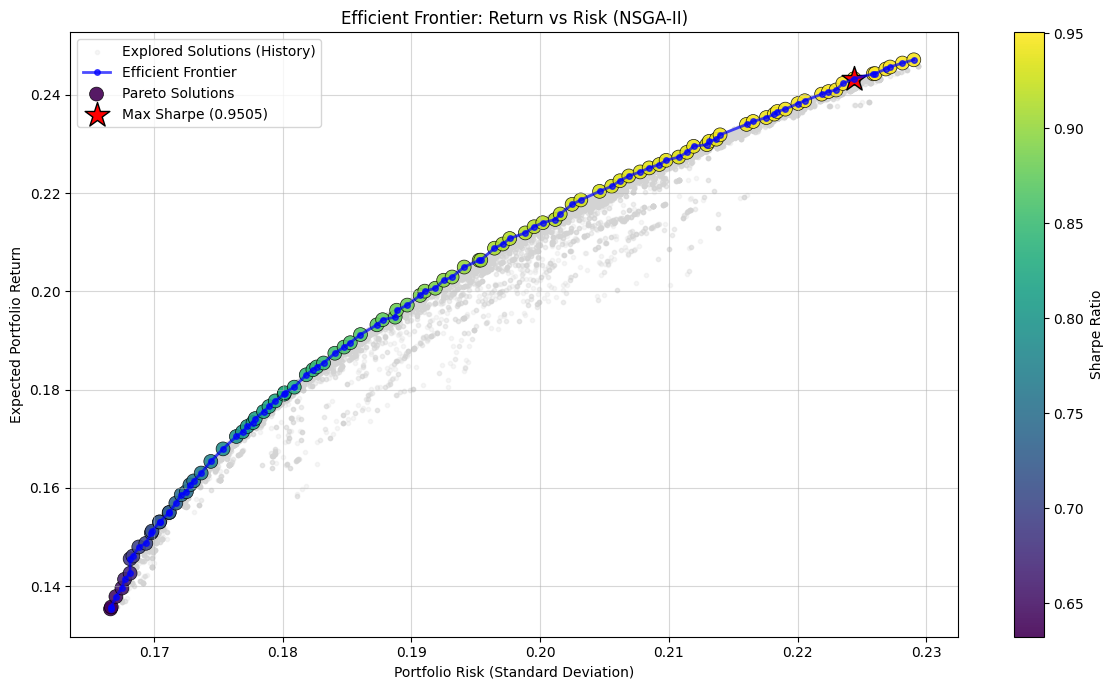

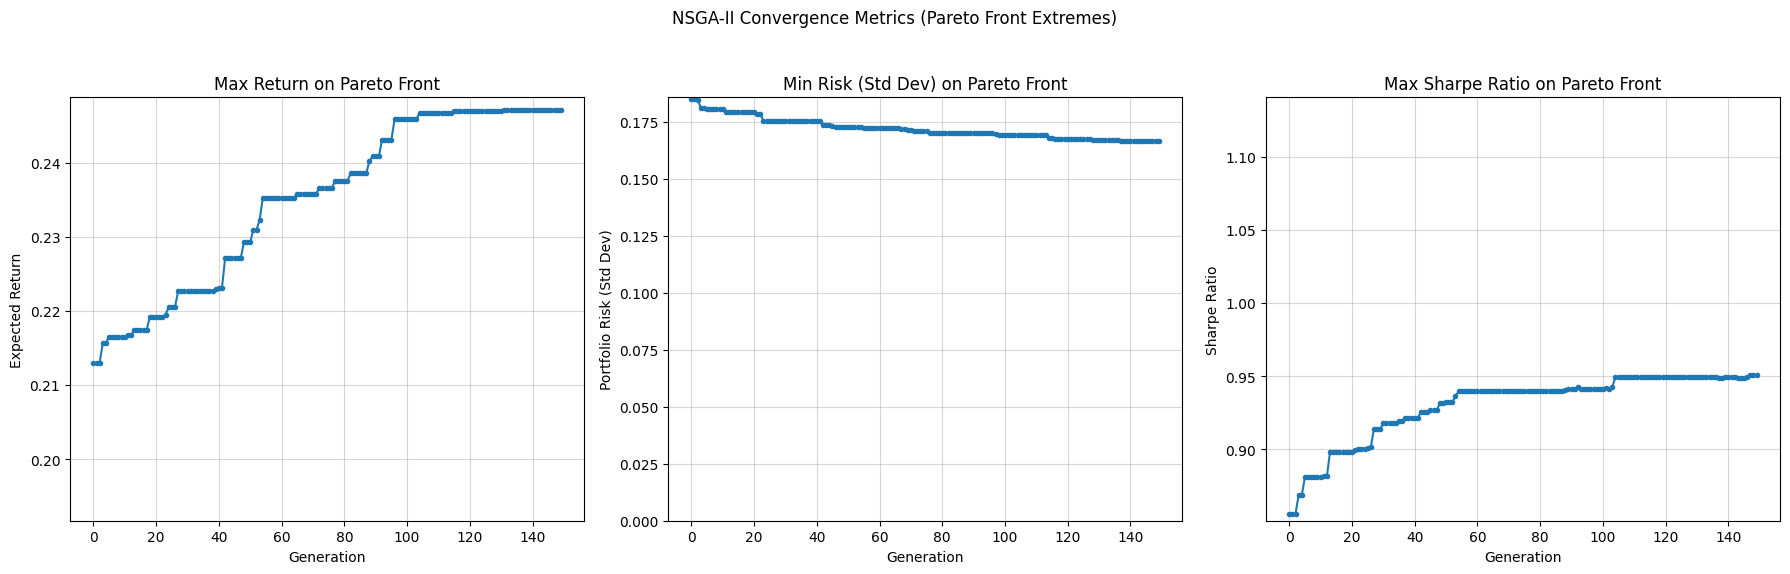


Best Portfolio (Highest Sharpe - 0.9505):
  Weights: 
    AAPL: 0.3987
    AMZN: 0.0441
    BAC: 0.0071
    BRK-B: 0.0332
    JNJ: 0.0299
    JPM: 0.0286
    MSFT: 0.2359
    PG: 0.1892
    V: 0.0112
    XOM: 0.0221
  Expected Return: 0.2433
  Risk (Std Dev):  0.2244
  Sharpe Ratio:    0.9505


In [21]:
tickers = ['AAPL', 'MSFT', 'AMZN', 'BRK-B', 'JNJ', 'JPM', 'V', 'PG', 'XOM', 'BAC']

start_date = '2018-01-01'
end_date = '2024-12-31'
mu, Sigma, asset_names = get_stock_data(tickers=tickers, start_date=start_date, end_date=end_date)
risk_free_rate = 0.03 

if mu is not None and Sigma is not None:
    num_assets = len(asset_names)
    print(f"\nSuccessfully loaded data for {num_assets} assets: {asset_names}")

    # Define our PortfolioOptimizerGA instance    
    optimizer = PortfolioOptimizerGA(
        num_assets=num_assets,
        mu=mu,
        Sigma=Sigma,
        population_size=100,    # Number of portfolios in each generation
        generations=150,      # Number of generations to run
        crossover_rate=0.9,   # Probability of crossover
        mutation_rate=1.0/num_assets, # Probability of mutating a single weight (1/num_assets)
        # mutation_strength=0.1, # Less relevant for polynomial mutation
        crossover_type=CrossoverType.SIMPLE_BLEND, # Good for real-coded GA
        risk_free_rate=risk_free_rate,
        sbx_eta=15.0,          # SBX tuning parameter
        poly_mutation_eta=20.0 # Polynomial mutation tuning parameter
    )

    # Call run on the optimizer
    pareto_solutions, pareto_metrics = optimizer.run() 

    # Results
    if pareto_solutions:
        print(f"\nNSGA-II found {len(pareto_solutions)} Pareto optimal portfolios.")

        optimizer.plot_efficient_frontier(pareto_metrics, all_metrics_history=optimizer.history)
        optimizer.plot_convergence()

        if pareto_metrics:
            sharpes = [m[2] for m in pareto_metrics]
            finite_sharpes = [(i, s) for i, s in enumerate(sharpes) if np.isfinite(s)]
            inf_sharpe_indices = [i for i, s in enumerate(sharpes) if s == float('inf')]

            best_sharpe_idx = -1
            if inf_sharpe_indices:
                    best_sharpe_idx = inf_sharpe_indices[0] # Pick first infinite Sharpe portfolio
                    print("\nBest Portfolio (Highest Sharpe - Infinite):")
            elif finite_sharpes:
                    best_sharpe_idx = max(finite_sharpes, key=lambda item: item[1])[0]
                    print(f"\nBest Portfolio (Highest Sharpe - {pareto_metrics[best_sharpe_idx][2]:.4f}):")
            else:
                    print("\nCould not determine best Sharpe portfolio.")


            if best_sharpe_idx != -1:
                best_weights = pareto_solutions[best_sharpe_idx]
                best_metrics = pareto_metrics[best_sharpe_idx]
                print("  Weights: ")
                for name, weight in zip(asset_names, best_weights):
                    if weight > 1e-4: # Only print non-negligible weights
                            print(f"    {name}: {weight:.4f}")
                print(f"  Expected Return: {best_metrics[0]:.4f}")
                print(f"  Risk (Std Dev):  {np.sqrt(max(0,best_metrics[1])):.4f}") # Ensure non-negative variance
                print(f"  Sharpe Ratio:    {best_metrics[2]:.4f}")

        else:
                print("\nNo metrics available to find the best Sharpe portfolio.")

    else:
        print("\nOptimization did not yield any Pareto solutions.")

else:
    print("\nCould not run optimization due to data loading errors.")

The best portfolio found by the NSGA-II algorithm, according to the highest Sharpe ratio (0.9505), demonstrates a well-diversified allocation across all 10 assets, with the largest weights assigned to AAPL (39.87%), MSFT (23.59%), and PG (18.92%). The remaining assets have smaller allocations, which helps to further diversify risk.

This Sharpe ratio indicates a strong risk-adjusted return, meaning the portfolio achieves a relatively high expected return for each unit of risk taken and, moreover, the weights reflect realistic investment allocations, with no single asset dominating excessively, and all weights remaining non-negative and summing to one, as required by the constraints.

## 5. Conclusions

This project successfully demonstrated the application of the Non-dominated Sorting Genetic Algorithm II (NSGA-II) to the classic portfolio optimization problem. By formulating the task as a multi-objective optimization problem - simultaneously maximizing expected return and minimizing portfolio variance (risk) - we leveraged the strengths of NSGA-II in handling conflicting objectives and exploring complex search spaces.

The implementation involved fetching historical stock data, calculating expected returns and the covariance matrix, and then employing the `PortfolioOptimizerGA` class. This class encapsulates the core NSGA-II logic, including non-dominated sorting, crowding distance calculation, selection, crossover (with options like SBX, blend, and uniform), and polynomial mutation, ensuring the generation of feasible portfolios (weights sum to 1, non-negative).

The results, visualized through the efficient frontier plot, clearly show the trade-off between risk and return. The algorithm effectively identified a set of Pareto-optimal portfolios, representing the best possible compromises an investor can make given the selected assets and historical data. Furthermore, the ability to pinpoint specific portfolios, such as the one maximizing the Sharpe ratio (starred in the plot), provides actionable insights for investment decisions.

The use of a genetic algorithm like NSGA-II proves advantageous, particularly in scenarios where traditional quadratic programming methods might struggle due to non-convexities or the inclusion of complex real-world constraints (though only basic constraints were used here). The convergence plots indicated that the algorithm progressively improved the quality and diversity of solutions over generations.

In conclusion, NSGA-II offers a robust and flexible framework for multi-objective portfolio optimization, capable of generating a diverse set of optimal solutions that cater to different risk preferences. Future work could involve incorporating more sophisticated risk measures (like CVaR), adding transaction costs, handling dynamic rebalancing, or exploring larger asset universes.

In [1]:
import os

os.system('jupyter nbconvert --to html 30592_FilippoAntonioRonzino_Project.ipynb')

[NbConvertApp] Converting notebook 30592_FilippoAntonioRonzino_Project.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 2 image(s).
[NbConvertApp] Writing 719169 bytes to 30592_FilippoAntonioRonzino_Project.html


0